In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import datasets
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras import optimizers, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np

In [2]:
import os

In [3]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Mounted at /content/drive


# 결과보고서
1. Dense Net을 이용해 "0.9 f1 score" 달성
2. 1D-CNN layer를 이용한 CNN을 통해 "0.89 f1 score" 달성
3. Overfitting 방지를 위해 두모델 다 아래 기법 사용;
   1. feature engineering을 통해 corr이 적은 feature 제거
   2. StandardScaler를 이용한 data normalization
   3. l2 regulalization 활용
   4. DropOut layer 활용
   

## 1. Data 확인하기


In [62]:
data_path = '/content/drive/MyDrive/gachon4-2/deeplearning/week2/Raisin_Dataset'

In [63]:
df = pd.DataFrame(pd.read_excel(os.path.join(data_path,"Raisin_Dataset.xlsx")))

In [64]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [65]:
print(np.unique(df['Class']))

['Besni' 'Kecimen']


In [66]:
# convert word to int
df.loc[df['Class'] == 'Besni', 'Class'] = 0
df.loc[df['Class'] == 'Kecimen', 'Class'] = 1

df['Class']=df['Class'].astype('int')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 56.4 KB


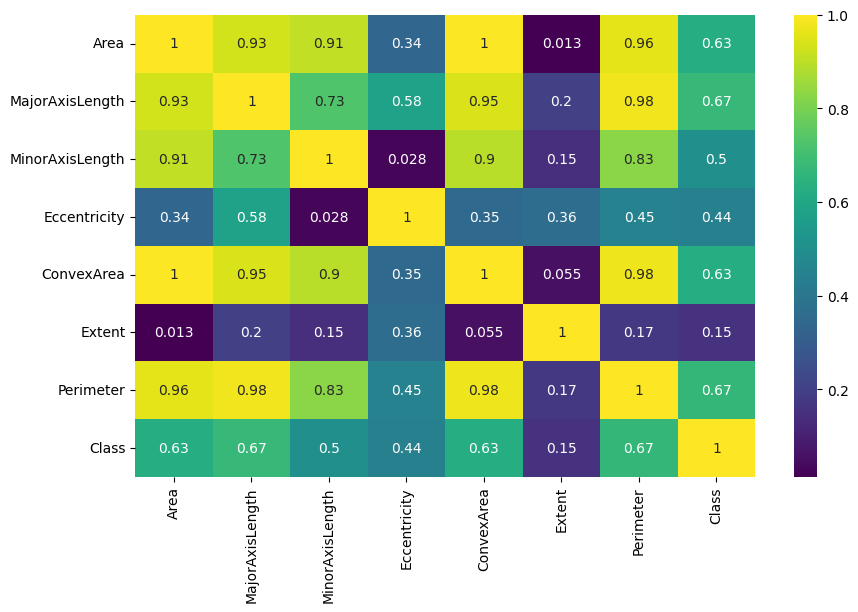

In [68]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(df.corr().abs(), annot=True, cmap="viridis");

In [69]:
df.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'Extent', 'Perimeter', 'Class'],
      dtype='object')

## 2. Data preprocessing

In [89]:
# X = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
#        'ConvexArea', 'Extent', 'Perimeter']].values

## corr 값이 작은 Extent, Eccentricity 제거
X = df[['Area', 'MajorAxisLength', 'MinorAxisLength','ConvexArea', 'Perimeter']].values
Y = df['Class'].values

In [90]:
X = np.asarray(X).astype('float32')
Y = np.asarray(Y).astype('float32')

In [91]:
print(X[:5])
print(Y[:5])

[[87524.        442.246     253.29115 90546.       1184.04   ]
 [75166.        406.69067   243.03244 78789.       1121.786  ]
 [90856.        442.26706   266.3283  93717.       1208.575  ]
 [45928.        286.54056   208.76004 47336.        844.162  ]
 [79408.        352.19077   290.82755 81463.       1073.251  ]]
[1. 1. 1. 1. 1.]


In [94]:
# from sklearn.preprocessing import MinMaxScaler
# mm = MinMaxScaler()
from sklearn.preprocessing import StandardScaler
mm = StandardScaler()
X_scaled = mm.fit_transform(X)

# One-hot encoding of y_train labels (only execute once!)
from keras.utils import to_categorical
Y2 = to_categorical(Y, num_classes= 2)
print('New y_train shape: ', Y2.shape)

New y_train shape:  (900, 2)


In [95]:
print(X_scaled[:5])
print(Y2[:5])

[[-0.00718637  0.09757686 -0.02395823 -0.01570903  0.06627411]
 [-0.3242172  -0.20901218 -0.22929215 -0.30424818 -0.16125241]
 [ 0.07829241  0.09775844  0.23698777  0.06211335  0.15594451]
 [-1.0742857  -1.2450513  -0.91527355 -1.0761647  -1.175915  ]
 [-0.21539338 -0.67895794  0.7273538  -0.23862314 -0.33863866]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [176]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y2, train_size=0.9, random_state=2, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=2, shuffle=True)

In [177]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(729, 5) (729, 2)
(81, 5) (81, 2)
(90, 5) (90, 2)


## 3-1. DNN modeling

In [168]:
# define model params
input_shape = x_train.shape[1]
output_shape = y_train.shape[1]
nodes = np.ceil(2 * input_shape / 3 + output_shape).astype(int)
batch_size = np.ceil(len(x_train) / 128).astype(int)

In [169]:
def DNN(input_size=(5,)):
  inputs=Input(input_size)
  regularizer=tf.keras.regularizers.l2(0)

  dense1 = Dense(nodes, activation='relu', kernel_regularizer = regularizer)(inputs)
  drop1 = Dropout(0.5)(dense1)
  dense2 = Dense(nodes, activation='relu', kernel_regularizer = regularizer)(drop1)
  drop2 = Dropout(0.5)(dense2)
  dense3 = Dense(nodes, activation='relu')(drop2)
  drop3 = Dropout(0.5)(dense3)

  outputs = Dense(2, activation='sigmoid')(drop3)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model



In [178]:
DNN_model = DNN()
DNN_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_85 (Dense)            (None, 6)                 36        
                                                                 
 dropout_56 (Dropout)        (None, 6)                 0         
                                                                 
 dense_86 (Dense)            (None, 6)                 42        
                                                                 
 dropout_57 (Dropout)        (None, 6)                 0         
                                                                 
 dense_87 (Dense)            (None, 6)                 42        
                                                                 
 dropout_58 (Dropout)        (None, 6)                 0  

In [179]:
# 모델 컴파일 하기
PATH= "/content/drive/MyDrive/gachon4-2/deeplearning/week2/"
model_checkpoint = ModelCheckpoint(filepath =  os.path.join(PATH,"model.h5"), monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20)

In [180]:
# 모델 학습
hist = DNN_model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 100, batch_size = batch_size,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_val, y_val),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping], # 저장 및 모니터링
                  shuffle=True
                 )



Epoch 1/100
116/122 [===========================>..] - ETA: 0s - loss: 0.6616 - accuracy: 0.6236
Epoch 1: val_loss improved from inf to 0.65725, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 3s 9ms/step - loss: 0.6646 - accuracy: 0.6200 - val_loss: 0.6573 - val_accuracy: 0.8765
Epoch 2/100
118/122 [============================>.] - ETA: 0s - loss: 0.6272 - accuracy: 0.6794
Epoch 2: val_loss improved from 0.65725 to 0.62078, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
122/122 [==============================] - 1s 5ms/step - loss: 0.6251 - accuracy: 0.6790 - val_loss: 0.6208 - val_accuracy: 0.8889
Epoch 3/100
112/122 [==========================>...] - ETA: 0s - loss: 0.6122 - accuracy: 0.7232
Epoch 3: val_loss improved from 0.62078 to 0.57671, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
122/122 [==============================] - 1s 5ms/step - loss: 0.6087 - accuracy: 0.7270 - val_loss: 0.5767 - val_accuracy: 0.9136
Epoch 4/100
116/122 [===========================>..] - ETA: 0s - loss: 0.5864 - accuracy: 0.7443
Epoch 4: val_loss improved from 0.57671 to 0.54099, saving

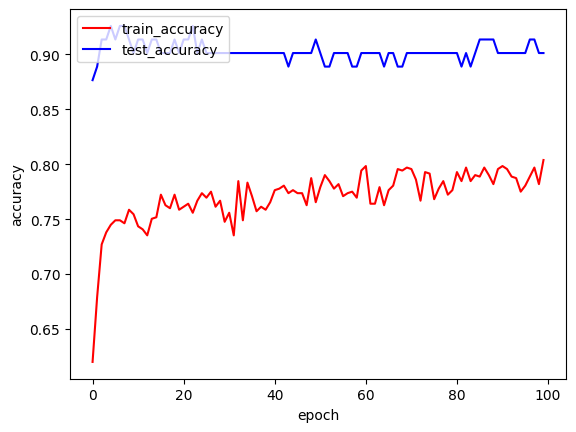

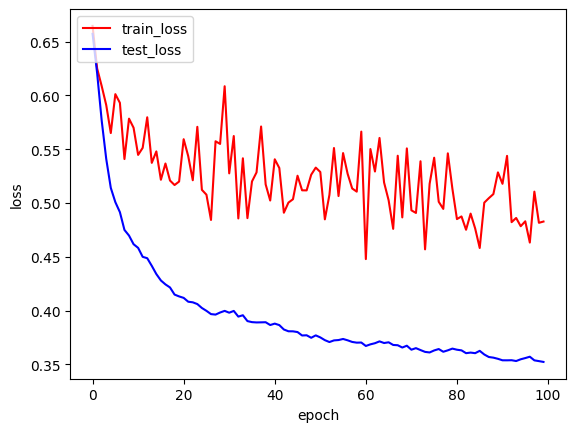

In [181]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], 'r', label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label = 'test_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(hist.history['loss'], 'r', label = 'train_loss')
plt.plot(hist.history['val_loss'], 'b', label = 'test_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## 4-1. DNN Evaluation

In [182]:
# 모델 평가
DNN_model.evaluate(x_test, y_test)

# 테스트 데이터 입력하여 예측값 구하기
prediction = DNN_model.predict(x_test)

# 3. perform evaluation on test set
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# evaluation for multi class classification
y_label = np.argmax(y_test,1)
y_pred = np.argmax(prediction,1)

print(classification_report(y_label, y_pred))
print('Accuracy Score:', metrics.accuracy_score(y_label, y_pred))

cm = confusion_matrix(y_label, y_pred)
print(cm)



3/3 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        47
           1       0.85      0.95      0.90        43

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.91      0.90      0.90        90

Accuracy Score: 0.9
[[40  7]
 [ 2 41]]


## 3-2. 1D-CNN modeling & Train

In [183]:
x_train.shape

(729, 5)

In [184]:
x_train=x_train[:,:,np.newaxis]
x_val=x_val[:,:,np.newaxis]
x_test=x_test[:,:,np.newaxis]

In [185]:
x_train.shape

(729, 5, 1)

In [217]:

from keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from keras import optimizers, Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def CNN_1D(input_size=(5,1)):
  inputs=Input(input_size)
  regularizer=tf.keras.regularizers.l2(0)

  conv = Conv1D(filters=6, kernel_size=2, activation='relu')(inputs)
  drop = Dropout(0.5)(conv)
  max = MaxPooling1D(pool_size=2)(drop)

  flat = Flatten()(max)

  outputs = Dense(2, activation='sigmoid')(flat)
  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [218]:
cnn_model = CNN_1D()
cnn_model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 5, 1)]            0         
                                                                 
 conv1d_20 (Conv1D)          (None, 4, 6)              18        
                                                                 
 dropout_73 (Dropout)        (None, 4, 6)              0         
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 2, 6)              0         
 ng1D)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 12)                0         
                                                                 
 dense_97 (Dense)            (None, 2)                 26        
                                                          

In [213]:
# 모델 컴파일 하기
PATH= "/content/drive/MyDrive/gachon4-2/deeplearning/week2/"
model_checkpoint = ModelCheckpoint(filepath =  os.path.join(PATH,"model.h5"), monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 20)

In [214]:
# 모델 학습
hist = cnn_model.fit(
                  x_train, y_train,                        # 입력 / 라벨
                  epochs = 100, batch_size = batch_size,            # 학습 회수 / 학습 10번 후 오차 감소
                  validation_data=(x_val, y_val),        # 검증 데이터
                  callbacks = [model_checkpoint, early_stopping], # 저장 및 모니터링
                  shuffle=True
                 )


Epoch 1/100
118/122 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.4534
Epoch 1: val_loss improved from inf to 0.65933, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 2s 9ms/step - loss: 0.6936 - accuracy: 0.4595 - val_loss: 0.6593 - val_accuracy: 0.8025
Epoch 2/100
119/122 [============================>.] - ETA: 0s - loss: 0.6296 - accuracy: 0.7129
Epoch 2: val_loss improved from 0.65933 to 0.60870, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
122/122 [==============================] - 1s 5ms/step - loss: 0.6281 - accuracy: 0.7133 - val_loss: 0.6087 - val_accuracy: 0.8765
Epoch 3/100
120/122 [============================>.] - ETA: 0s - loss: 0.5760 - accuracy: 0.7694
Epoch 3: val_loss improved from 0.60870 to 0.53998, saving model to /content/drive/MyDrive/gachon4-2/deeplearning/week2/model.h5
122/122 [==============================] - 1s 5ms/step - loss: 0.5737 - accuracy: 0.7709 - val_loss: 0.5400 - val_accuracy: 0.8889
Epoch 4/100
118/122 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7980
Epoch 4: val_loss improved from 0.53998 to 0.45206, saving

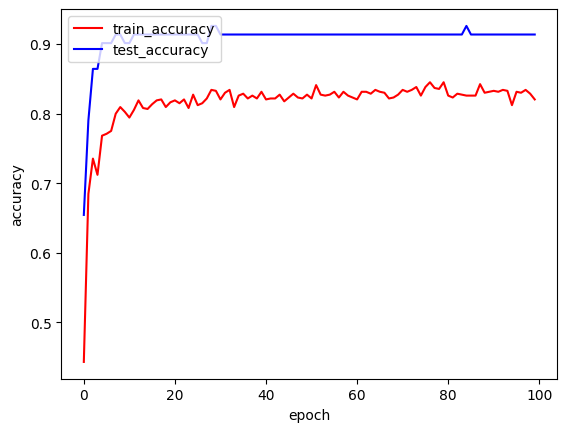

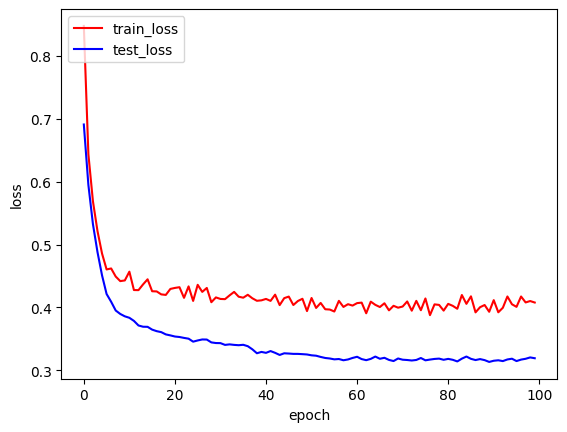

In [207]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], 'r', label = 'train_accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label = 'test_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(hist.history['loss'], 'r', label = 'train_loss')
plt.plot(hist.history['val_loss'], 'b', label = 'test_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

## 4-2. 1D-CNN Evaluation

In [208]:
# 모델 평가
cnn_model.evaluate(x_test, y_test)

# 테스트 데이터 입력하여 예측값 구하기
prediction = cnn_model.predict(x_test)

# 3. perform evaluation on test set
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# evaluation for multi class classification
y_label = np.argmax(y_test,1)
y_pred = np.argmax(prediction,1)

print(classification_report(y_label, y_pred))
print('Accuracy Score:', metrics.accuracy_score(y_label, y_pred))

cm = confusion_matrix(y_label, y_pred)
print(cm)



3/3 [==============================] - 0s 16ms/step - loss: 0.3650 - accuracy: 0.8889


3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        47
           1       0.87      0.91      0.89        43

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90

Accuracy Score: 0.8888888888888888
[[41  6]
 [ 4 39]]
